## Imports

In [1]:
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from einops import einsum
from torch.utils.data.dataset import Dataset

## Create the dataset [MNIST]

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)

In [3]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

## Define the model

In [4]:
import torch
import torch.nn as nn

class VectorQuantizer(nn.Module):
    """
    Instead of quantizing to a single value, each encoded output gets quantized to a vector 
    """
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost

        # Embedding codebook (num_embeddings entries, each of size embedding_dim)
        self.embeddings = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embeddings.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)

    def forward(self, x):
        # Flatten the input (B, C, H, W) -> (B*H*W, C)
        flat_input = x.view(-1, self.embedding_dim)
        
        # Compute the distances between input and each embedding
        distances = torch.cdist(flat_input.unsqueeze(0), self.embeddings.weight.unsqueeze(0), p=2).squeeze(0)
        
        # Find the closest embedding for each element in the matrix
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        
        # Quantize: replace input with the closest embedding
        quantized = self.embeddings(encoding_indices).view(x.shape)
        
        # Loss to encourage the latent output to stick to discrete codes (commitment loss)
        e_latent_loss = F.mse_loss(quantized.detach(), x)
        q_latent_loss = F.mse_loss(quantized, x.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # Straight-through estimator for backpropagation
        quantized = x + (quantized - x).detach()
        
        return quantized, loss, encoding_indices

# VQ-VAE Encoder
class VQVAEEncoder(nn.Module):
    def __init__(self, embedding_dim):
        super(VQVAEEncoder, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # (B, 1, 28, 28) -> (B, 32, 14, 14)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # (B, 32, 14, 14) -> (B, 64, 7, 7)
            nn.ReLU(),
            nn.Conv2d(64, embedding_dim, kernel_size=1)            # (B, 64, 7, 7) -> (B, embedding_dim, 7, 7)
        )
    
    def forward(self, x):
        return self.conv_layer(x)  # Output: (B, embedding_dim, 7, 7)

# VQ-VAE Decoder
class VQVAEDecoder(nn.Module):
    def __init__(self, embedding_dim):
        super(VQVAEDecoder, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # (B, embedding_dim, 7, 7) -> (B, 64, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),            # (B, 64, 14, 14) -> (B, 32, 28, 28)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),                               # (B, 32, 28, 28) -> (B, 1, 28, 28)
            nn.Sigmoid()  # Output range [0, 1]
        )

    def forward(self, x):
        return self.conv_layer(x)

# VQ-VAE Model
class VQVAE(nn.Module):
    def __init__(self, embedding_dim=16, num_embeddings=8, commitment_cost=0.25):
        super(VQVAE, self).__init__()
        self.encoder = VQVAEEncoder(embedding_dim)
        self.decoder = VQVAEDecoder(embedding_dim)
        self.quantizer = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
    
    def forward(self, x):
        # Encode input
        encoded = self.encoder(x)  # Output: (B, embedding_dim, 7, 7)
        
        # Quantize each element in the 7x7 feature map
        quantized, vq_loss, quantized_indices = self.quantizer(encoded)
        
        # Decode the quantized representation
        reconstructed = self.decoder(quantized)
        
        return reconstructed, vq_loss, quantized_indices


## Define training procedure

In [5]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 10
OPTIMIZER_LR = 1e-3

In [7]:
# Load the data
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
# Model, optimizer
reconstruction_loss_fn = nn.BCELoss()
vqvae = VQVAE().to(device)
optimizer = torch.optim.Adam(vqvae.parameters(), lr=OPTIMIZER_LR)

In [9]:
# Training loop
vqvae.train()
for epoch in range(NUM_EPOCHS):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)

        reconstructed, vq_loss, _ = vqvae(data)
        reconstruction_loss = reconstruction_loss_fn(reconstructed, data)
        total_loss = reconstruction_loss + vq_loss
        
        total_loss.backward()
        optimizer.step()
        
        train_loss += total_loss.item()

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {train_loss/len(train_loader.dataset):.4f}')


Epoch [1/10], Loss: 0.0822
Epoch [2/10], Loss: 0.0357
Epoch [3/10], Loss: 0.0310
Epoch [4/10], Loss: 0.0299
Epoch [5/10], Loss: 0.0297
Epoch [6/10], Loss: 0.0297
Epoch [7/10], Loss: 0.0298
Epoch [8/10], Loss: 0.0300
Epoch [9/10], Loss: 0.0299
Epoch [10/10], Loss: 0.0299


## Testing reconstruction on training images

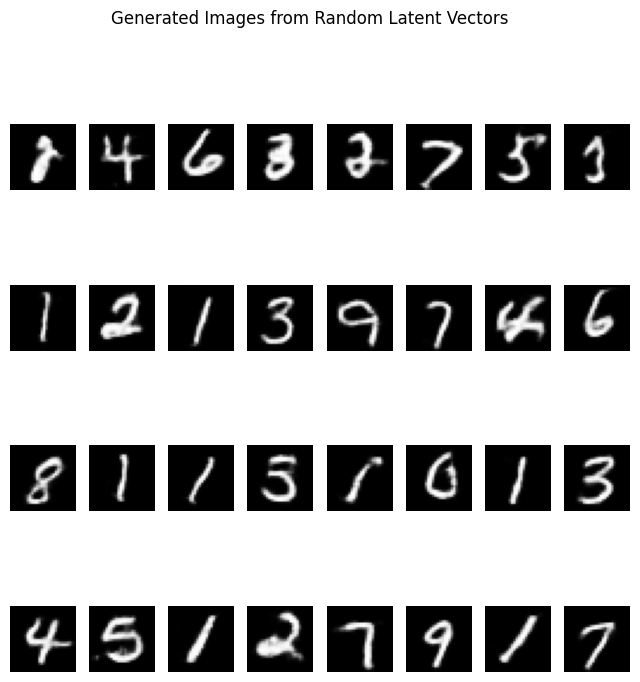

In [10]:
# Reconstructed images of a batch in the training set the generated images in an 4x8 grid
fig, axes = plt.subplots(4, 8, figsize=(8, 8))
for i in range(32):
    row, col = divmod(i, 8)
    axes[row, col].imshow(reconstructed[i][0].detach().cpu().numpy(), cmap='gray')
    axes[row, col].axis('off')

plt.suptitle('Generated Images from Random Latent Vectors')
plt.show()

## Generating Images by training an LSTM
As explained in this [video](https://www.youtube.com/watch?v=1ZHzAOutcnw) by ExplainingAI. (Currently not working)

In [11]:
# Load MNIST test dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_test = datasets.MNIST(root="./data", train=False, download=False, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True)

In [12]:
# vqvae.eval()
# with torch.no_grad():
#     for batch,label in test_loader:
#         test_reconstructed,_,_ = vqvae(batch.to(device))
#         break

# # Reconstructed images of a batch in the training set the generated images in an 8x8 grid
# fig, axes = plt.subplots(8, 8, figsize=(8, 8))
# for i in range(64):
#     row, col = divmod(i, 8)
#     axes[row, col].imshow(test_reconstructed[i][0].detach().cpu().numpy(), cmap='gray')
#     axes[row, col].axis('off')

# plt.suptitle('Generated Images from Random Latent Vectors')
# plt.show()

In [13]:
vqvae.eval()
save_encodings = None
print('Saving Encodings for lstm')
with torch.no_grad():
    for im, _ in tqdm(test_loader):
        im = im.float().to(device)
        _,_,quant_indices = vqvae(im)
        # print(quant_indices.reshape(-1,7,7).shape, save_encodings.shape if save_encodings is not None else None)
        save_encodings = quant_indices.reshape(-1,7,7) if save_encodings is None else torch.cat([save_encodings, quant_indices.reshape(-1,7,7)], dim=0)
print('Done saving encoder outputs for lstm for training')

Saving Encodings for lstm


100%|██████████| 157/157 [00:00<00:00, 173.27it/s]

Done saving encoder outputs for lstm for training


In [14]:
save_encodings.shape

torch.Size([10000, 7, 7])

In [15]:
class LSTMLatentGenerator(nn.Module):
    def __init__(self, embedding_dim=16, num_embeddings=8, hidden_dim=128, num_layers=2):
        super(LSTMLatentGenerator, self).__init__()
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(hidden_dim, hidden_dim // 4),
                                nn.ReLU(),
                                nn.Linear(hidden_dim // 4, num_embeddings))
        self.word_embedding = nn.Embedding(num_embeddings+2, embedding_dim)

    def forward(self, x):
        x = self.word_embedding(x)
        output, _ = self.lstm(x)
        output = output[:, -1, :]
        return self.fc(output)

In [19]:
class LSTMDataset(Dataset):
    r"""
    Dataset for training of LSTM. Assumes the encodings are already generated
    by running vqvae inference
    """
    def __init__(self, encodings):
        self.codebook_size = 8
        
        # Codebook tokens will be 0 to codebook_size-1
        self.start_token = self.codebook_size
        self.pad_token = self.codebook_size+1
        # Fix context size
        self.context_size = 32
        self.sents = self.load_sents(encodings)
    
    def load_sents(self, encodings):
        mnist_encodings = encodings.reshape(encodings.size(0), -1)
        num_encodings = mnist_encodings.size(0)
        padded_sents = []
        
        for encoding_idx in tqdm(range(num_encodings)):
            # Use only 10% encodings.
            # Uncomment this for getting some kind of output quickly validate working
            if random.random() > 0.1:
                continue
            enc = mnist_encodings[encoding_idx]
            encoding_length = enc.shape[-1]

            # Make sure all encodings start with start token
            enc = torch.cat([torch.ones((1)).to(device) * self.start_token, enc.to(device)])
            
            # Create batches of context sized inputs(if possible) and target
            sents = [(enc[:i], enc[i]) if i < self.context_size else (enc[i - self.context_size:i], enc[i])
                   for i in range(1, encoding_length+1)]
            
            for context, target in sents:
                # Pad token if context not enough
                if len(context) < self.context_size:
                    context = torch.nn.functional.pad(context, (0, self.context_size-len(context)), "constant", self.pad_token)
                padded_sents.append((context, target))
        return padded_sents
    
    def __len__(self):
        return len(self.sents)
    
    def __getitem__(self, index):
        context, target = self.sents[index]
        return context, target

In [20]:
def train_lstm(save_encodings):
    ############## Create dataset ###########
    mnist = LSTMDataset(save_encodings)
    mnist_seq_loader = DataLoader(mnist, batch_size=32, shuffle=True, num_workers=0)
    #########################################
    
    ############## Create LSTM ###########
    model = LSTMLatentGenerator().to(device)
    model.to(device)
    model.train()
    
    ############## Training Params ###########
    num_epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=1E-3)
    criterion = torch.nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        losses = []
        for sent, target in tqdm(mnist_seq_loader):
            sent = sent.to(device).long()
            target = target.to(device).long()
            optimizer.zero_grad()
            pred = model(sent)
            loss = torch.mean(criterion(pred, target))
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print('Epoch {} : {}'.format(epoch, np.mean(losses)))
        print('=' * 50)
    return model

In [21]:
gen_lstm = train_lstm(save_encodings)

100%|██████████| 1515/1515 [00:07<00:00, 207.33it/s]


Epoch 0 : 1.8494714395441239


100%|██████████| 1515/1515 [00:07<00:00, 203.63it/s]


Epoch 1 : 1.5556871710830789


100%|██████████| 1515/1515 [00:07<00:00, 213.81it/s]


Epoch 2 : 1.3951932518002224


100%|██████████| 1515/1515 [00:07<00:00, 214.86it/s]


Epoch 3 : 1.3392320583362392


100%|██████████| 1515/1515 [00:07<00:00, 214.33it/s]


Epoch 4 : 1.2990889100745173


100%|██████████| 1515/1515 [00:06<00:00, 223.89it/s]


Epoch 5 : 1.2555552948426099


100%|██████████| 1515/1515 [00:06<00:00, 217.59it/s]


Epoch 6 : 1.2276898411634338


100%|██████████| 1515/1515 [00:06<00:00, 217.03it/s]


Epoch 7 : 1.1901660287734306


100%|██████████| 1515/1515 [00:06<00:00, 217.73it/s]


Epoch 8 : 1.1590712438715567


100%|██████████| 1515/1515 [00:06<00:00, 225.89it/s]


Epoch 9 : 1.1303393334445386


In [25]:
def generate(vqvae_model, lstm, mnist_encodings):
    ########## Load VQVAE Model ##############
    vqvae_model.to(device)
    vqvae_model.eval()
    #########################################
    
    ########## Load LSTM ##############
    lstm.to(device)
    lstm.eval()
    #########################################
    
    ################ Generate Samples #############
    generated_quantized_indices = []
    mnist_encodings_length = mnist_encodings.reshape(mnist_encodings.size(0), -1).shape[-1]
    # Assume fixed contex size
    context_size = 32
    num_samples = 100
    print('Generating Samples')
    for _ in tqdm(range(num_samples)):
        # Initialize with start token
        ctx = torch.ones((1)).to(device) * 8
        
        for i in range(mnist_encodings_length):
            padded_ctx = ctx
            if len(ctx) < context_size:
                # Pad context with pad token
                padded_ctx = torch.nn.functional.pad(padded_ctx, (0, context_size - len(ctx)), "constant", 9)
                
            out = lstm(padded_ctx[None, :].long().to(device))
            probs = torch.nn.functional.softmax(out, dim=-1)
            pred = torch.multinomial(probs[0], num_samples=1)
            # Update the context with the new prediction
            ctx = torch.cat([ctx, pred])
        generated_quantized_indices.append(ctx[1:][None, :])
        
    ######## Decode the Generated Indices ##########
    generated_quantized_indices = torch.cat(generated_quantized_indices, dim=0)
    h = int(generated_quantized_indices[0].size(-1)**0.5)
    quantized_indices = generated_quantized_indices.reshape((generated_quantized_indices.size(0), h, h)).long()
    quantized_indices = torch.nn.functional.one_hot(quantized_indices, 8)
    quantized_indices = quantized_indices.permute((0, 3, 1, 2))
    qunatized_output = einsum(quantized_indices.float(), vqvae.quantizer.embeddings.weight, 'b n h w, n d -> b d h w')
    output = vqvae.decoder(qunatized_output)
    return output


In [26]:
images = generate(vqvae, gen_lstm, save_encodings)

Generating Samples


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:02<00:00, 39.44it/s]


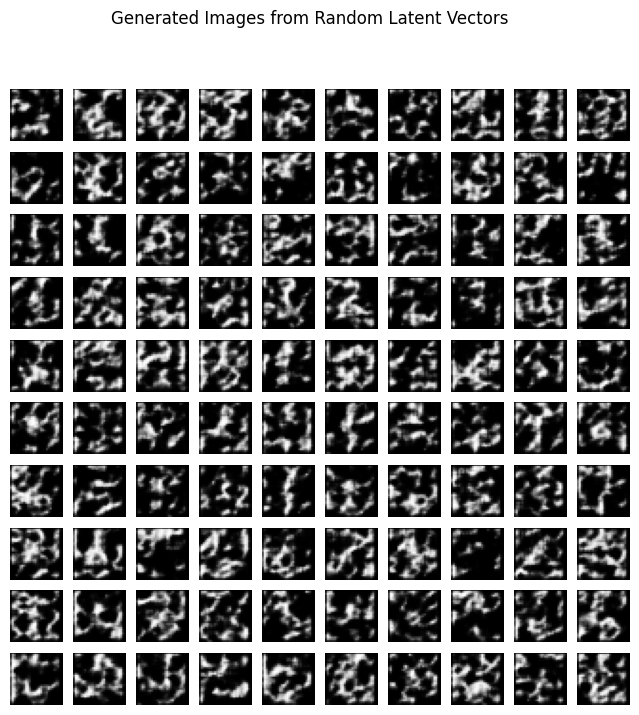

In [27]:
# Reconstructed images of a batch in the training set the generated images in an 4x8 grid
fig, axes = plt.subplots(10, 10, figsize=(8, 8))
for i in range(100):
    row, col = divmod(i, 10)
    axes[row, col].imshow(images[i][0].detach().cpu().numpy(), cmap='gray')
    axes[row, col].axis('off')

plt.suptitle('Generated Images from Random Latent Vectors')
plt.show()